In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
import os

# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")
print(os.getcwd())

/mnt/raid/bling/bram/multilang_timescale


In [4]:
import json 

import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

from adjustText import adjust_text

from src.utils.plot import config_plotting, figsize_dict, create_discrete_cmap, id_to_label
from src.utils.meta import read_result_meta
from src.utils.utils import get_valid_voxels
from src.utils.weight import process_primal_weight
from src.settings import TrainerSetting


from src.utils.utils import (
    two_side_ks_test,
    timescale_permutation_test, 
)

In [5]:
config_plotting('paper')
# get default font size
default_font_size = plt.rcParams['font.size']

In [6]:
image_dir = ".temp/image/semantic_cluster/"

result_metric = "r2"    
result_meta_dir = ".temp/result_meta/bling"
alpha = 0.05
r2_threshold = 0.1

cluster_centroids_file = ".temp/misc/semantic_cluster/cluster_centroids_bling.npy"

In [7]:
subject_ids = ['COL', 'GFW', 'TYE']

In [8]:
def load_semantic_weight_data(subject_id):
    subject_file_en = f".temp/config/bling/subject/{subject_id}_en.json"
    subject_file_zh = f".temp/config/bling/subject/{subject_id}_zh.json"

    feature_file_en = f".temp/config/bling/feature/{subject_id}/fasttext_stepwise_en.json"
    feature_file_zh = f".temp/config/bling/feature/{subject_id}/fasttext_stepwise_zh.json"

    trainer_en_file = (
        f".temp/config/bling/train/stepwise/{subject_id.lower()}_en-save_primal.json"
    )
    trainer_zh_file = (
        f".temp/config/bling/train/stepwise/{subject_id.lower()}_zh-save_primal.json"
    )
    # loading semantic vem

    en_meta_df = read_result_meta(
        result_meta_dir,
        trainer_setting_path=trainer_en_file,
        subject_setting_path=subject_file_en,
        feature_setting_path=feature_file_en,
    )
    zh_meta_df = read_result_meta(
        result_meta_dir,
        trainer_setting_path=trainer_zh_file,
        subject_setting_path=subject_file_zh,
        feature_setting_path=feature_file_zh,
    )
        
    en_config = en_meta_df.iloc[0].to_dict()
    zh_config = zh_meta_df.iloc[0].to_dict()

    en_stat = en_config["stats_path"]
    en_stat = np.load(en_stat)

    zh_stat = zh_config["stats_path"]
    zh_stat = np.load(zh_stat)

    valid_en_voxel_mask, valid_en_voxel_idx = get_valid_voxels(en_stat, metric=result_metric, score_threshold=r2_threshold, alpha=alpha)
    valid_zh_voxel_mask, valid_zh_voxel_idx = get_valid_voxels(zh_stat, metric=result_metric, score_threshold=r2_threshold, alpha=alpha)

    en_joint_pred_acc = en_stat[f"test_joint_{result_metric}_score_mask"]
    zh_joint_pred_acc = zh_stat[f"test_joint_{result_metric}_score_mask"]

    # # get sqrt
    if result_metric == 'r2':
        en_joint_pred_acc = np.sqrt(np.maximum(en_joint_pred_acc, 0))
        zh_joint_pred_acc = np.sqrt(np.maximum(zh_joint_pred_acc, 0))

    return {
        'en': {
            'config': en_config,
            'stat': en_stat,
            'valid_voxel_mask': valid_en_voxel_mask,
            'valid_voxel_idx': valid_en_voxel_idx,
            'joint_pred_acc': en_joint_pred_acc
        },
        'zh': {
            'config': zh_config,
            'stat': zh_stat,
            'valid_voxel_mask': valid_zh_voxel_mask,
            'valid_voxel_idx': valid_zh_voxel_idx,
            'joint_pred_acc': zh_joint_pred_acc
        }
    }

In [9]:
def load_timescale_data(subject_id):
    subject_file_en = f".temp/config/bling/subject/{subject_id}_en.json"
    subject_file_zh = f".temp/config/bling/subject/{subject_id}_zh.json"

    trainer_en_ts_file = (
        f".temp/config/bling/train/stepwise/{subject_id.lower()}_en_timescale.json"
    )

    trainer_zh_ts_file = (
        f".temp/config/bling/train/stepwise/{subject_id.lower()}_zh_timescale.json"
    )

    feature_file_en_ts = f".temp/config/bling/feature/{subject_id}/mBERT_all_untrimmed_timescale_stepwise_en.json"
    feature_file_zh_ts = f".temp/config/bling/feature/{subject_id}/mBERT_all_untrimmed_timescale_stepwise_zh.json"

    # loading timescale vem
    en_meta_df = read_result_meta(
        result_meta_dir,
        trainer_setting_path=trainer_en_ts_file,
        subject_setting_path=subject_file_en,
        feature_setting_path=feature_file_en_ts,)

    zh_meta_df = read_result_meta(
        result_meta_dir,
        trainer_setting_path=trainer_zh_ts_file,
        subject_setting_path=subject_file_zh,
        feature_setting_path=feature_file_zh_ts,
    )

    # load trainer json file to TrainerSetting
    en_ts_config = en_meta_df.iloc[0].to_dict()
    zh_ts_config = zh_meta_df.iloc[0].to_dict()
        
    en_ts_stat = en_ts_config["stats_path"]
    en_ts_stat = np.load(en_ts_stat)

    zh_ts_stat = zh_ts_config["stats_path"]
    zh_ts_stat = np.load(zh_ts_stat)

    valid_en_ts_voxel_mask, valid_en_ts_voxel_idx = get_valid_voxels(en_ts_stat, metric=result_metric, score_threshold=r2_threshold, alpha=alpha)
    valid_zh_ts_voxel_mask, valid_zh_ts_voxel_idx = get_valid_voxels(zh_ts_stat, metric=result_metric, score_threshold=r2_threshold, alpha=alpha)

    en_timescale = en_ts_stat[f"test_{result_metric}_selectivity_mask"]
    zh_timescale = zh_ts_stat[f"test_{result_metric}_selectivity_mask"]

    return {
        'en': en_timescale,
        'zh': zh_timescale,

        'en_valid_idx': valid_en_ts_voxel_idx,
        'zh_valid_idx': valid_zh_ts_voxel_idx,
    }

In [10]:
def get_primal_weight(semantic_weight_data):
    en_primal_weight = semantic_weight_data["en"]["config"]["primal_weights_path"]
    zh_primal_weight = semantic_weight_data["zh"]["config"]["primal_weights_path"]

    en_primal_weight = np.load(en_primal_weight)["primal_weights"]
    zh_primal_weight = np.load(zh_primal_weight)["primal_weights"]

    en_primal_weight = np.squeeze(en_primal_weight)
    zh_primal_weight = np.squeeze(zh_primal_weight)

    en_primal_weight = process_primal_weight(
        en_primal_weight,
        prediction_score=semantic_weight_data["en"]["joint_pred_acc"],
        normalize=True,
    )
    zh_primal_weight = process_primal_weight(
        zh_primal_weight,
        prediction_score=semantic_weight_data["zh"]["joint_pred_acc"],
        normalize=True,
    )

    return {"en": en_primal_weight, "zh": zh_primal_weight}

In [11]:
timescales = {}
for subject_id in subject_ids:
    timescales[subject_id] = load_timescale_data(subject_id)

In [12]:
semantic_maps = {}
for subject_id in subject_ids:
    semantic_maps[subject_id] = load_semantic_weight_data(subject_id)

In [13]:
primal_weights = {}
for subject_id in subject_ids:
    primal_weights[subject_id] = get_primal_weight(semantic_maps[subject_id])

In [14]:
# loading fasttext embeddings
centroids = np.load(cluster_centroids_file)
centroids = centroids[[0,1,3,4], :]

n_clusters = centroids.shape[0]

en_fasttext = ".temp/misc/word_list/en_fasttext_embeddings.npy"
zh_fasttext = ".temp/misc/word_list/zh_fasttext_embeddings.npy"

en_fasttext = np.load(en_fasttext, allow_pickle=True).tolist()
zh_fasttext = np.load(zh_fasttext, allow_pickle=True).tolist()

en_words = list(en_fasttext.keys())
zh_words = list(zh_fasttext.keys())

# get word from en_words and zh_words
en_words = np.array(en_words)
zh_words = np.array(zh_words)

# now get all value from en_fasttext dictionary and project that to pca
en_fasttext_values = np.array(list(en_fasttext.values()))
zh_fasttext_values = np.array(list(zh_fasttext.values()))


In [15]:
def cluster_weights(primal_weight, centroids):
    def cluster(x, centroids):
        return np.argmin(np.linalg.norm(x - centroids, axis=1))
    
    en_cluster = np.array([cluster(x, centroids) for x in primal_weight['en']])
    zh_cluster = np.array([cluster(x, centroids) for x in primal_weight['zh']])

    return {
        'en': en_cluster,
        'zh': zh_cluster
    }

In [16]:
clustered_weights = {}
for subject_id in subject_ids:
    clustered_weights[subject_id] = cluster_weights(primal_weights[subject_id], centroids)

In [17]:
def get_timescale_per_cluster(clustered_weight, timescale, semantic_map, n_clusters = 5, join_mode='all'):
    en_cluster_voxels = clustered_weight['en']
    zh_cluster_voxels = clustered_weight['zh']

    en_timescale = timescale['en']
    zh_timescale = timescale['zh']

    en_semantic_valid_idx = semantic_map['en']['valid_voxel_idx']
    zh_semantic_valid_idx = semantic_map['zh']['valid_voxel_idx']

    en_timescale_valid_idx = timescale['en_valid_idx']
    zh_timescale_valid_idx = timescale['zh_valid_idx']
    
    if join_mode == 'all':
        joint_valid_idx = np.intersect1d(en_semantic_valid_idx, zh_semantic_valid_idx)
        joint_valid_idx = np.intersect1d(joint_valid_idx, en_timescale_valid_idx)
        joint_valid_idx = np.intersect1d(joint_valid_idx, zh_timescale_valid_idx)

        en_valid_idx = joint_valid_idx
        zh_valid_idx = joint_valid_idx
    else:
        en_valid_idx = np.intersect1d(en_semantic_valid_idx, en_timescale_valid_idx)
        zh_valid_idx = np.intersect1d(zh_semantic_valid_idx, zh_timescale_valid_idx)
    
    timescale_per_cluster = {}

    for i in range(n_clusters):
        en_cluster_idx = np.where(en_cluster_voxels == i)[0]
        zh_cluster_idx = np.where(zh_cluster_voxels == i)[0]

        joint_en_idx = np.intersect1d(en_cluster_idx, en_valid_idx)
        joint_zh_idx = np.intersect1d(zh_cluster_idx, zh_valid_idx)

        en_cluster_timescale = en_timescale[joint_en_idx]
        zh_cluster_timescale = zh_timescale[joint_zh_idx]

        timescale_per_cluster[i] = {
            'en': en_cluster_timescale,
            'zh': zh_cluster_timescale
        }
    
    return timescale_per_cluster

In [18]:
timescales_per_clusters = {}

for subject_id in subject_ids:
    timescales_per_clusters[subject_id] = get_timescale_per_cluster(
        clustered_weights[subject_id], timescales[subject_id], semantic_maps[subject_id], n_clusters=n_clusters, join_mode='all')

In [19]:
def plot_histograms(timescales_per_clusters, subject_id, axs = None, cmap='hls', plot_ylabel=False, n_clusters=4, write_timescale_label=True, write_pval=False):
    cmap = create_discrete_cmap(n_clusters, palette=cmap)

    if axs is None:
        fig, axs = plt.subplots(n_clusters, 1, figsize=(15, 15), sharex=True,sharey=True)
    # share x axis
    
    pvals = []

    for i in range(n_clusters):
        en_timescale = timescales_per_clusters[subject_id][i]['en']
        zh_timescale = timescales_per_clusters[subject_id][i]['zh']

        # plot en zh but different line style
        sns.kdeplot(en_timescale, ax=axs[i], label='en', color=cmap(i), linestyle='--')
        sns.kdeplot(zh_timescale, ax=axs[i], label='zh', color=cmap(i), linestyle='-')   
        
        
        axs[i].set_xlim(8, 256)
        
        if write_pval:
            pval, _ = timescale_permutation_test(en_timescale, zh_timescale)        
            axs[i].text(0.0, 0.8, f'p={pval:.2f}', transform=axs[i].transAxes, fontsize=default_font_size)    
        
        
    # remove yticks for all but first
    # for i in range(1, n_clusters):
    #     axs[i].set_yticklabels([])
    #axs[-1].set_yticklabels([])
    # remove ylabels for all but the first
    if not plot_ylabel:
        for i in range(n_clusters):
            axs[i].set_ylabel('')
    # remove xticks for all but last
    # for i in range(n_clusters-1):
    #     axs[i].set_xticklabels([])
    # for i in range(n_clusters):
    #     axs[i].set_ylabel('')
    
    # # remove y label for all but the middle
    # if plot_ylabel:
    #     for i in range(n_clusters):
    #         if i != 2:
    #             axs[i].set_ylabel('')
    #         else:
    #             axs[i].set_ylabel('Density')
    
    # # set subject id as title for first plot
    # axs[0].set_title(subject_id)

    if write_timescale_label:
        axs[-1].set_xlabel('Timescale selectivity (words)')
        
    
    return axs

In [20]:
en_fasttext_values.shape

(2749, 300)

In [21]:
def compute_cosine_similarity(
    fasttext_pca: np.ndarray, cluster_centers: np.ndarray
):
    similarity = cosine_similarity(fasttext_pca, cluster_centers)
    return similarity

def compute_euclidean_distance(
    fasttext_pca: np.ndarray, cluster_centers: np.ndarray
):
    similarity = euclidean_distances(fasttext_pca, cluster_centers)
    return similarity

def plot_text_pca(ax=None, n_words=20, skip=3):
    en_cos_sim = compute_cosine_similarity(en_fasttext_values, centroids)
    zh_cos_sim = compute_cosine_similarity(zh_fasttext_values, centroids)
    # now for each center, pick 10 words that has highest cosine similarity

    en_words_idx = np.argsort(en_cos_sim, axis=0)[-n_words:][::-1]
    zh_words_idx = np.argsort(zh_cos_sim, axis=0)[-n_words:][::-1]

    # get the cluster idx for each word
    en_cluster_idx = np.argmax(en_cos_sim, axis=1)
    zh_cluster_idx = np.argmax(zh_cos_sim, axis=1)

    # get cluster from en_words_idx 
    en_cluster_words = en_words[en_words_idx]
    zh_cluster_words = zh_words[zh_words_idx]

    # get vector for each cluster
    en_word_vector = en_fasttext_values[en_words_idx]
    zh_word_vector = zh_fasttext_values[zh_words_idx]


    # do pca and plot
    from sklearn.decomposition import PCA

    pca = PCA(n_components=2)

    en_word_vector_flattened = en_word_vector.reshape(-1, en_word_vector.shape[-1])
    zh_word_vector_flattened = zh_word_vector.reshape(-1, zh_word_vector.shape[-1])

    # join them 
    word_vector = np.vstack([en_fasttext_values, zh_fasttext_values])

    pca.fit(word_vector)

    en_word_vector_pca = pca.transform(en_word_vector_flattened)
    zh_word_vector_pca = pca.transform(zh_word_vector_flattened)

    # reshape them back
    en_word_vector_pca = en_word_vector_pca.reshape(en_word_vector.shape[0], en_word_vector.shape[1], 2)
    zh_word_vector_pca = zh_word_vector_pca.reshape(zh_word_vector.shape[0], zh_word_vector.shape[1], 2)

    en_word_vector_pca = en_word_vector_pca[::skip, :]
    zh_word_vector_pca = zh_word_vector_pca[::skip, :]

    en_cluster_words = en_cluster_words[::skip, :]
    zh_cluster_words = zh_cluster_words[::skip, :]

    from matplotlib import font_manager

    font_path = ".temp/font/SourceHanSerifK-Light.otf"
    font_manager.fontManager.addfont(font_path)
    prop = font_manager.FontProperties(fname=font_path)


    # now plot en_cluster_words and zh_cluster_words in pca space
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    cmap = create_discrete_cmap(n_clusters, palette='hls')

    texts = []
    for i in range(n_clusters):
        en_cluster_pca = en_word_vector_pca[:,i,:].squeeze()
        zh_cluster_pca = zh_word_vector_pca[:,i,:].squeeze()

        ax.scatter(en_cluster_pca[:, 0], en_cluster_pca[:, 1], label=f"en_cluster_{i}", color=cmap(i), s=0)
        ax.scatter(zh_cluster_pca[:, 0], zh_cluster_pca[:, 1], label=f"zh_cluster_{i}", color=cmap(i), s=0)

        for j, txt in enumerate(en_cluster_words[:, i].squeeze()):
            # skip if txt len ==1
            if len(txt) > 1:
                texts.append(ax.annotate(txt, (en_cluster_pca[j, 0], en_cluster_pca[j, 1]), color=cmap(i)))
        
        for j, txt in enumerate(zh_cluster_words[:,i].squeeze()):
            texts.append(ax.annotate(txt, (zh_cluster_pca[j, 0], zh_cluster_pca[j, 1]), fontproperties=prop, color=cmap(i)))
        
        # for j, txt in enumerate(en_cluster_words[:, i].squeeze()):
        #     texts.append(ax.text(en_cluster_pca[j, 0], en_cluster_pca[j, 1], txt, color=cmap(i),))
        # for j, txt in enumerate(zh_cluster_words[:,i].squeeze()):
        #     texts.append(ax.text(zh_cluster_pca[j, 0], zh_cluster_pca[j, 1], txt, color=cmap(i), fontproperties=prop))
            
    adjust_text(texts, alw=1.0)
    ax.set_ylabel('PC 2')
    ax.set_xlabel('PC 1')
    # remove ticks
    
    # print out the words
    for i in range(n_clusters):
        print(f"Cluster {i}")
        print("EN")
        print(en_cluster_words[:, i].squeeze())
        print("ZH")
        print(zh_cluster_words[:, i].squeeze())
    return ax

Cluster 0
EN
['brooklyn' 'j' 'tartabull' 'six' 'boston' 'eight' 'g']
ZH
['皮' '七十' '戴' '特' '乔治' '十九' '坡']
Cluster 1
EN
['campus' 'semester' 'boulder' 'park' 'home' 'road' 'york']
ZH
['前往' '大厅' '来到' '参观' '沿着' '营地' '殡仪馆']
Cluster 2
EN
['asked' 'wife' 'apologize' 'daughter' 'answered' 'telling' 'married']
ZH
['打电话' '告诉' '女儿' '回答' '后悔' '劝慰' '母亲']
Cluster 3
EN
['wife' 'girlfriend' 'mother' 'father' 'friend' 'grandchild' 'grandfather']
ZH
['妻子' '打电话' '男友' '母亲' '家人' '嫂子' '出生']


/tmp/ipykernel_522137/3794972324.py:44: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


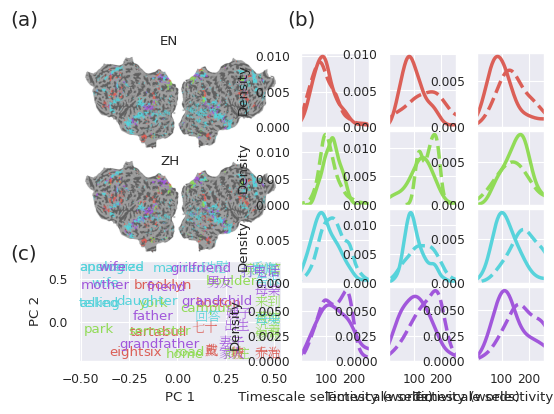

In [22]:
fig = plt.figure(figsize=figsize_dict['full'])

# gridspec
gs = fig.add_gridspec(12, 4, width_ratios=[0.6, 0.2, 0.2, 0.2])

ax_en_flatmap= fig.add_subplot(gs[:4, 0])
ax_zh_flatmap = fig.add_subplot(gs[4:8, 0])

en_flatmap = plt.imread(os.path.join(image_dir, f"COL/en_cluster.png"))
zh_flatmap = plt.imread(os.path.join(image_dir, f"COL/zh_cluster.png"))

ax_en_flatmap.imshow(en_flatmap)
ax_zh_flatmap.imshow(zh_flatmap)

ax_en_flatmap.axis('off')
ax_zh_flatmap.axis('off')

# now plot text pca
ax_text_pca = fig.add_subplot(gs[8:, 0])

plot_text_pca(ax=ax_text_pca)

# now second row for COL histogram, 
col_hist_axs = [fig.add_subplot(gs[i*3:(i+1)*3, 1]) for i in range(n_clusters)]
col_hist_axs = plot_histograms(timescales_per_clusters, 'COL', axs=col_hist_axs, plot_ylabel=True, n_clusters=n_clusters)

# now second row for GFW histogram,
gfw_hist_axs = [fig.add_subplot(gs[i*3:(i+1)*3, 2]) for i in range(n_clusters)]
gfw_hist_axs = plot_histograms(timescales_per_clusters, 'GFW', axs=gfw_hist_axs, n_clusters=n_clusters)

# now second row for TYE histogram,
tye_hist_axs = [fig.add_subplot(gs[i*3:(i+1)*3, 3]) for i in range(n_clusters)]
tye_hist_axs = plot_histograms(timescales_per_clusters, 'TYE', axs=tye_hist_axs, n_clusters=n_clusters)

# add (a) in the top left corner
fig.text(0.01, 0.95, "(a)", fontsize=default_font_size*1.5)
fig.text(0.4725, 0.95, "(b)", fontsize=default_font_size*1.5)
fig.text(0.01, 0.3625, "(c)", fontsize=default_font_size*1.5)

# add EN and ZH label
fig.text(0.26, 0.9, "EN", fontsize=default_font_size)
fig.text(0.26, 0.6, "ZH", fontsize=default_font_size)

plt.tight_layout()

fig_fn = os.path.join(image_dir, "timescale_cluster_agg.png")

plt.savefig(fig_fn, dpi=300, bbox_inches='tight')

plt.show()

Cluster 0
EN
['brooklyn' 'brown' 'merrill' 'tartabull' 'george']
ZH
['皮' '杵' '布' '戴' '马']
Cluster 1
EN
['campus' 'avenue' 'parking' 'boulder' 'halls']
ZH
['前往' '搬到' '门口' '来到' '客厅']
Cluster 2
EN
['asked' 'asks' 'told' 'apologize' 'girlfriend']
ZH
['打电话' '回信' '结婚' '女儿' '再婚']
Cluster 3
EN
['wife' 'married' 'remarried' 'mother' 'boyfriend']
ZH
['妻子' '再婚' '女儿' '男友' '儿子']


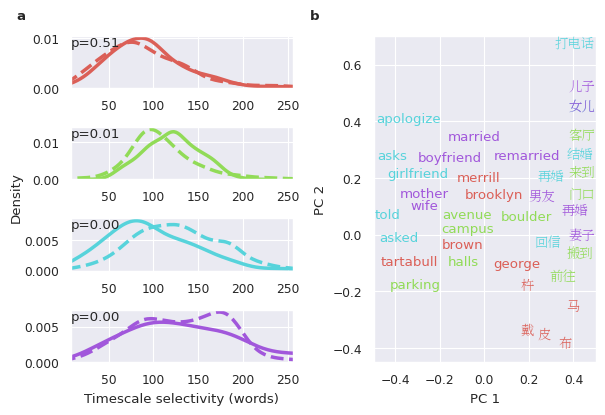

In [26]:
fig = plt.figure(figsize=(6,4))


# gridspec
gs = fig.add_gridspec(4, 2,)

# ax_en_flatmap= fig.add_subplot(gs[0, :3])
# ax_zh_flatmap = fig.add_subplot(gs[0, 3:])

# en_flatmap = plt.imread(os.path.join(image_dir, f"COL/en_cluster.png"))
# zh_flatmap = plt.imread(os.path.join(image_dir, f"COL/zh_cluster.png"))

# ax_en_flatmap.imshow(en_flatmap)
# ax_zh_flatmap.imshow(zh_flatmap)

# ax_en_flatmap.axis('off')
# ax_zh_flatmap.axis('off')

ax_text_pca = fig.add_subplot(gs[:, 1])
plot_text_pca(ax=ax_text_pca, skip=2, n_words=10)


col_hist_axs = [
    fig.add_subplot(gs[0, 0])
]

# add other axes to col_hist_axs, share x axis and y
for i in range(1, n_clusters):
    col_hist_axs.append(fig.add_subplot(gs[i, 0], sharex=col_hist_axs[0]))
    
# col_hist_axs[1].yaxis.set_tick_params(labelleft=False)

# set title for first plot, align to left
    
col_hist_axs = plot_histograms(timescales_per_clusters, 'COL', axs=col_hist_axs, plot_ylabel=False, n_clusters=n_clusters, write_pval=True)


# write (a) and (b) for each column
fig.text(0.01, 1.0, "a", fontsize=default_font_size, fontweight="bold")
fig.text(0.5, 1.0, "b", fontsize=default_font_size, fontweight="bold" )

# write density 
fig.text(0.0, 0.5, "Density", fontsize=default_font_size, rotation=90)

plt.tight_layout()

fig_fn = os.path.join(image_dir, "timescale_cluster_col.png")

plt.savefig(fig_fn, dpi=300, bbox_inches='tight')

plt.show()

plotting COL en
plotting COL zh
plotting GFW en
plotting GFW zh
plotting TYE en
plotting TYE zh


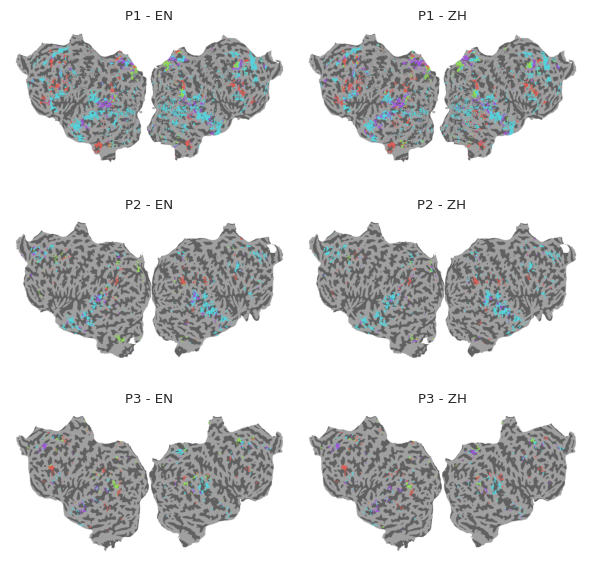

In [24]:
fig = plt.figure(figsize=(6,6))

gs = fig.add_gridspec(3, 4, height_ratios=[1, 1, 1], width_ratios=[1, 1, 1, 1])

languages = ['en', 'zh']

for i,id in enumerate(subject_ids):
    for j, lang in enumerate(languages):
        print(f"plotting {id} {lang}")        
        ax = fig.add_subplot(gs[i, j*2:j*2+2])
                    
        flatmap = plt.imread(os.path.join(image_dir, f"{id}/{lang}_cluster.png"))

        ax.imshow(flatmap)

        ax.axis('off')
        # write language on top middle
        ax.set_title(f"{id_to_label[id]} - {lang.upper()}")

        # write subject id if first column


# add legend with color        
# save images
save_path= os.path.join(image_dir, "flatmap_cluster.png")

if not os.path.exists(os.path.dirname(save_path)):
    os.makedirs(os.path.dirname(save_path))

plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()


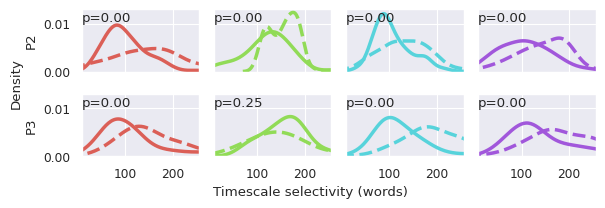

In [25]:
# now histogram
fig, axs = plt.subplots(2, 4, figsize=(6, 2), sharex=True, sharey=True)

plot_histograms(timescales_per_clusters, 'GFW', axs=axs[0,:], write_timescale_label=False, write_pval=True)
plot_histograms(timescales_per_clusters, 'TYE', axs=axs[1, :], write_timescale_label=False, write_pval=True)

axs[0, 0].set_ylabel(f'{id_to_label["GFW"]}')
axs[1, 0].set_ylabel(f'{id_to_label["TYE"]}')

# write label at bottom middle
fig.text(0.5, 0.0, 'Timescale selectivity (words)', ha='center')
fig.text(0.0, 0.45, "Density", fontsize=default_font_size, rotation=90)

# save images
save_path= os.path.join(image_dir, "flatmap_dist-tye-gfw.png")

if not os.path.exists(os.path.dirname(save_path)):
    os.makedirs(os.path.dirname(save_path))

plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()
